In [1]:
%load_ext autoreload
%autoreload 2

import torch
import experiments.multiclass_classification as exp
from experiments import mnist

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
batch_size = 128
# LeNet with ReLu
layers = [
    ("conv", (1, 6, 5)),
    ("relu", ()),
    ("pool", 2),
    ("conv", (6, 16, 5)),
    ("relu", ()),
    ("pool", 2),
    ("flatten", ()),
    ("fc", (16 * 4 * 4, 120)),
    ("relu", ()),
    ("fc", (120, 84)),
    ("relu", ()),
    ("fc", (84, 10)),
    ("logsoftmax", ())
]

In [4]:
torch.manual_seed(42)

trainloader = mnist.fashion_trainloader(batch_size)
testloader = mnist.fashion_testloader(batch_size)
corrupted_testloader = mnist.corrupted_fashion_testloader(batch_size)

In [5]:
torch.manual_seed(42)
pp, pp_losses = exp.point_predictor(layers, 10, trainloader, batch_size, device)

Generated model: Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=256, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
  (12): LogSoftmax(dim=1)
)
44426 trainable parameters
Epoch 0: NLL loss 0.014485659077763557
Epoch 1: NLL loss 0.006489911116659641
Epoch 2: NLL loss 0.005457732826471329
Epoch 3: NLL loss 0.005010807886719704
Epoch 4: NLL loss 0.004672571085393429
Epoch 5: NLL loss 0.004407860338687897
Epoch 6: NLL loss 0.004207390360534191
Epoch 7: NLL loss 0.004032253287732601
Epoch 8: NLL loss 0.003865925595164299
Epoch 9: NLL lo

In [13]:
torch.manual_seed(42)
swag_config = {
    "update_every_batches": len(trainloader) // 8,
    "deviation_samples": 15,
    "start_epoch": 8,
    "max_lr": 0.01,
    "min_lr": 0.005,
}
swag, swag_losses = exp.swag(layers, 10, trainloader, batch_size, swag_config, device)

Generated model: Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=256, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
  (12): LogSoftmax(dim=1)
)
44426 trainable parameters
Epoch 0: NLL loss 0.014485497027635574
Epoch 1: NLL loss 0.006489770952612162
Epoch 2: NLL loss 0.0054590762592852116
Epoch 3: NLL loss 0.005011415109038353
Epoch 4: NLL loss 0.00467276107519865
Epoch 5: NLL loss 0.0044065979309380054
Epoch 6: NLL loss 0.004205946810543537
Epoch 7: NLL loss 0.004031444434076548
Epoch 8: NLL loss 0.0038651498034596443
Epoch 9: NLL 

In [7]:
from training.bbb import GaussianPrior

torch.manual_seed(42)
bbb_prior = GaussianPrior(0, 1)
bbb, bbb_loss = exp.bbb(bbb_prior, "activations", 5, 1, layers, 10, trainloader, batch_size, device)

Generated model: Sequential(
  (0): BBBConvolution()
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): BBBConvolution()
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): BBBLinear()
  (8): ReLU()
  (9): BBBLinear()
  (10): ReLU()
  (11): BBBLinear()
  (12): LogSoftmax(dim=1)
)
88852 trainable parameters
Epoch 0: loss 3.4160778522491455
Epoch 1: loss 2.8029396533966064
Epoch 2: loss 2.662581443786621
Epoch 3: loss 2.592597007751465
Epoch 4: loss 2.5508368015289307
Epoch 5: loss 2.5203545093536377
Epoch 6: loss 2.4965269565582275
Epoch 7: loss 2.4754865169525146
Epoch 8: loss 2.4585187435150146
Epoch 9: loss 2.4428787231445312
Final loss 2.4428787231445312


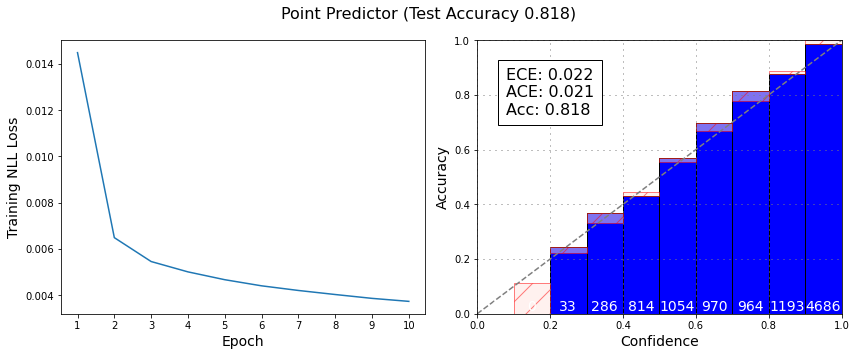

In [12]:
exp.eval_model("Point Predictor", pp, pp_losses, 1, testloader, device).savefig("figures/fmnistc_pp_10e.png")

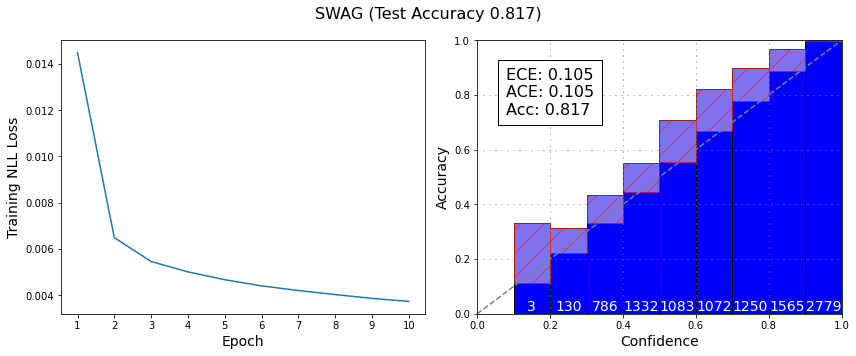

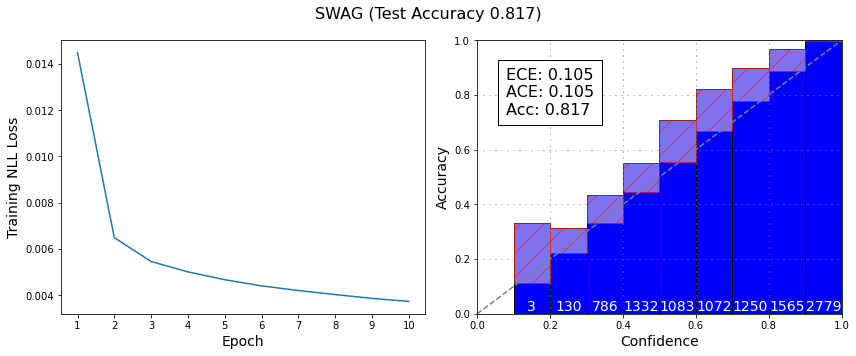

In [14]:
exp.eval_model("SWAG", swag, swag_losses, 100, testloader, device)

ACE average confidences: tensor([0.2180, 0.3025, 0.3599, 0.4168, 0.4906, 0.5946, 0.7224, 0.8557, 0.9505,
        0.9914])


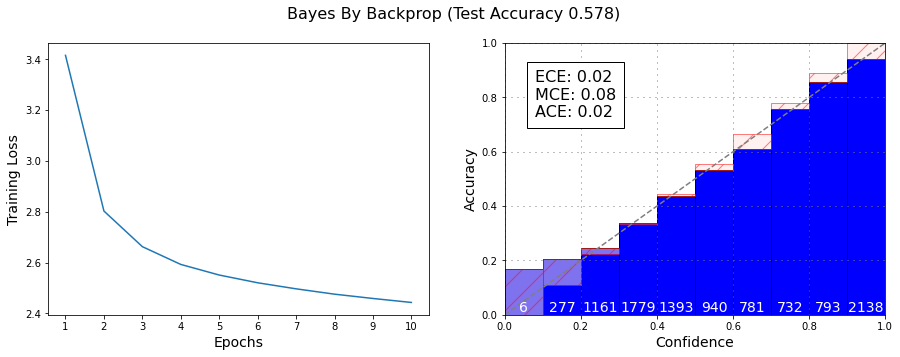

In [30]:
exp.eval_model("Bayes By Backprop", bbb, bbb_loss, 100, corrupted_testloader, device)

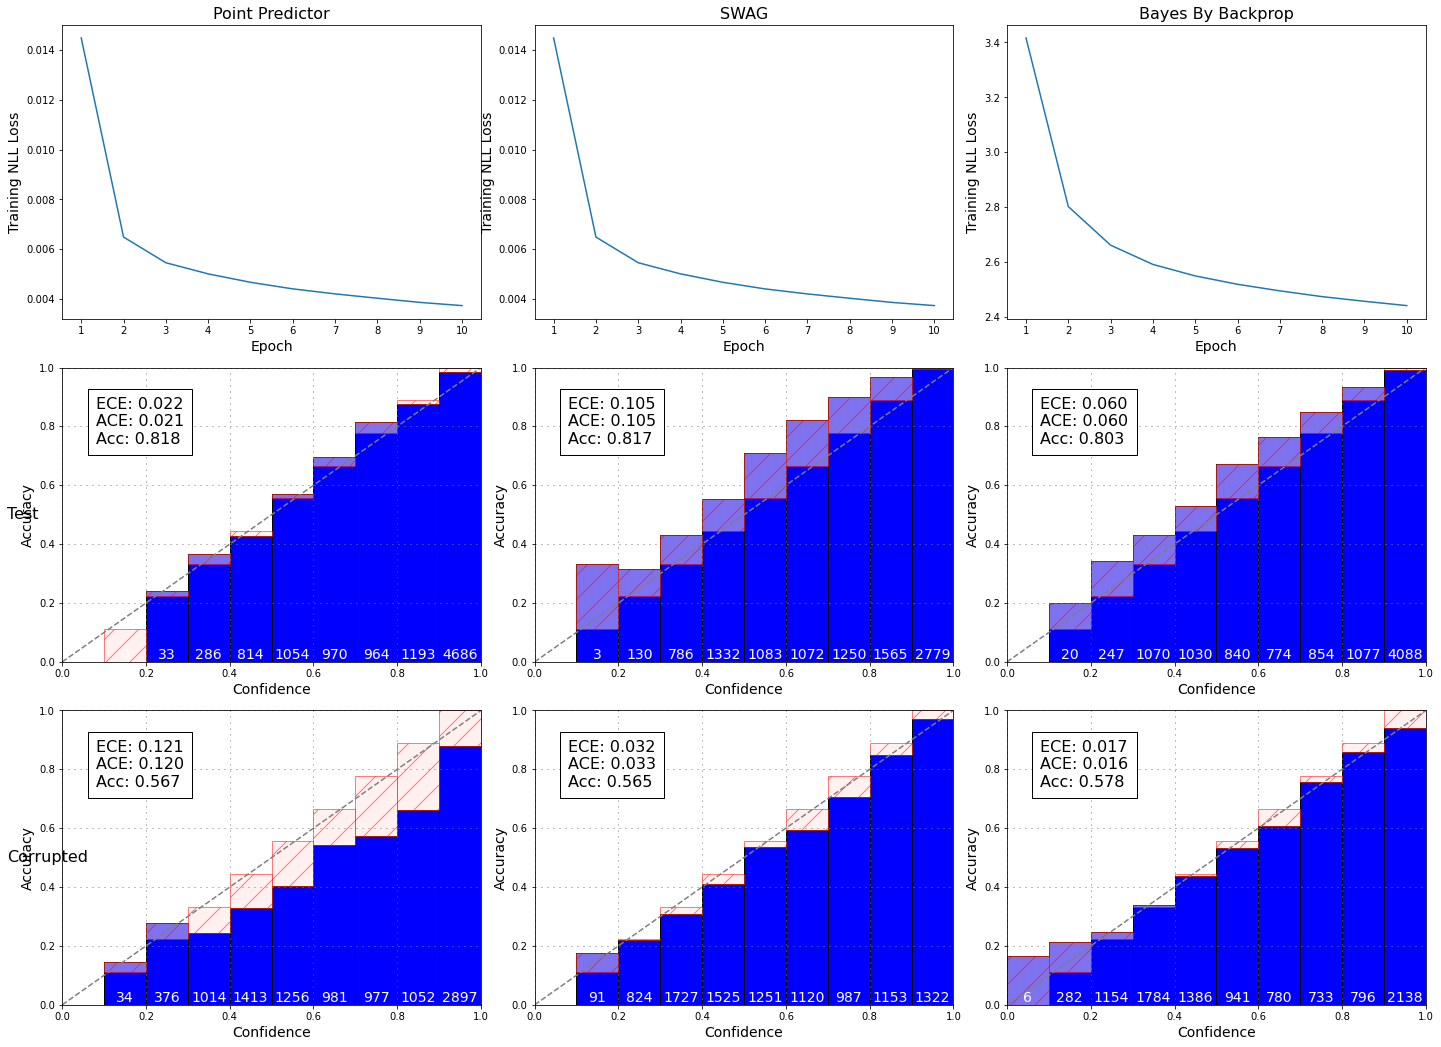

In [15]:
exp.eval_multiple(
    [
        ("Point Predictor", pp, pp_losses, [], 1),
        ("SWAG", swag, swag_losses, [], 100),
        ("Bayes By Backprop", bbb, bbb_loss, [], 100)
    ],
    [
        ("Test", testloader),
        ("Corrupted", corrupted_testloader)
    ],
    device
).savefig("figures/mnist_all.png")